In [82]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sksurv.datasets import load_flchain
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

plt.rcParams['figure.figsize'] = [7.2, 4.8]

In [83]:
x, y = load_flchain()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [84]:
num_columns = ['age', 'creatinine', 'kappa', 'lambda']

imputer = SimpleImputer().fit(x_train.loc[:, num_columns])
x_train = imputer.transform(x_train.loc[:, num_columns])
x_test = imputer.transform(x_test.loc[:, num_columns])

In [85]:
y_events = y_train[y_train['death']]
train_min, train_max = y_events["futime"].min(), y_events["futime"].max()

y_events = y_test[y_test['death']]
test_min, test_max = y_events["futime"].min(), y_events["futime"].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

In [86]:
times = np.percentile(y["futime"], np.linspace(5, 81, 15))
print(times)

[ 470.3        1259.         1998.         2464.82428571 2979.
 3401.         3787.99857143 4051.         4249.         4410.17285714
 4543.         4631.         4695.         4781.         4844.        ]


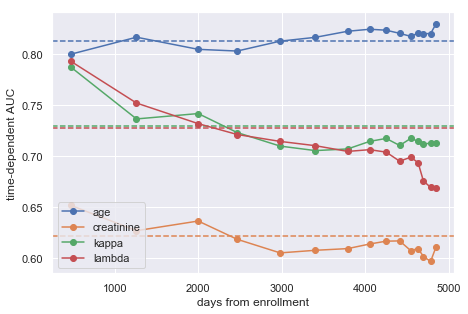

In [87]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

    
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test[:, i], col, color="C{}".format(i))
    ret = concordance_index_ipcw(y_train, y_test, x_test[:, i], tau=times[-1])

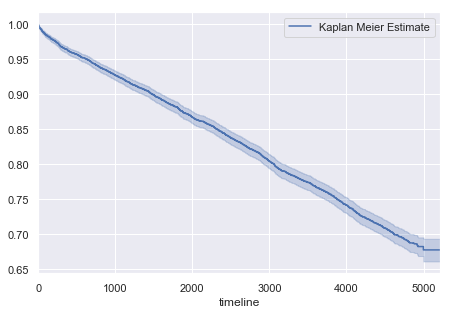

In [88]:
## Lets create an overall KaplanMeier curve
import lifelines

from lifelines import KaplanMeierFitter

durations = y_train['futime'] ## Time to event data of censored and event data
event_observed = y_train['death']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

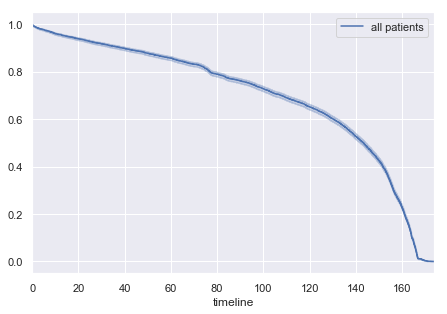

In [89]:
# Duration of patient following in months
T = [i / 30. for i in y_train["futime"]]
# Observation of death in boolean
# True for observed event (death);
# else False (this includes death not observed; death by other causes)
C = [True if i is not pd.NaT else False for i in y_train["death"]]

fitter = KaplanMeierFitter()
fitter.fit(T, event_observed=C, label="all patients")
fitter.plot(show_censors=True)

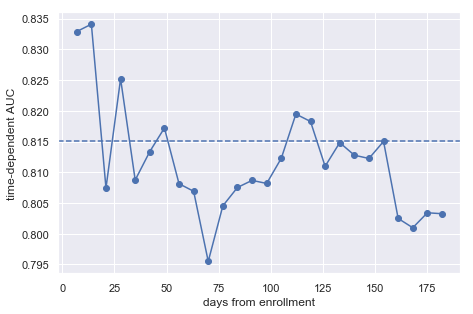

In [90]:
va_x, va_y = load_flchain()
va_x = va_x.drop(columns="chapter")
va_x['creatinine'] = va_x['creatinine'].fillna(va_x['creatinine'].median())

cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(va_x, va_y)

va_times = np.arange(7, 183, 7)
# estimate performance on training data, thus use `va_y` twice.
va_auc, va_mean_auc = cumulative_dynamic_auc(va_y, va_y, cph.predict(va_x), va_times)

plt.plot(va_times, va_auc, marker="o")
plt.axhline(va_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

dataset: https://stat.ethz.ch/R-manual/R-devel/library/survival/html/flchain.html

In [91]:
import os
# print(os.listdir(""))
import seaborn as sns
sns.set(rc={'figure.figsize':(18,10)})

In [92]:
df = pd.read_csv("flchain.csv")

cols= ['age', 'sex', 'sample.yr', 'kappa', 'lambda', 'flc.grp', 'creatinine', 'mgus', 'futime', 'death', 'chapter']
df = df[cols]
#fill NaN value with Mediam value
df['creatinine'] = df['creatinine'].fillna(df['creatinine'].median())
#Let F = 1, M = 0
d = {'F':0, 'M':1}
df['sex'] = df['sex'].apply(lambda x:d[x])
df.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,0,1997,5.70,4.860,10,1.7,0,85,1,Circulatory
1,92,0,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms
2,94,0,1997,4.36,3.850,10,1.4,0,69,1,Circulatory
3,92,0,1996,2.42,2.220,9,1.0,0,115,1,Circulatory
4,93,0,1996,1.32,1.690,6,1.1,0,1039,1,Circulatory


0    5705
1    2169
Name: death, dtype: int64


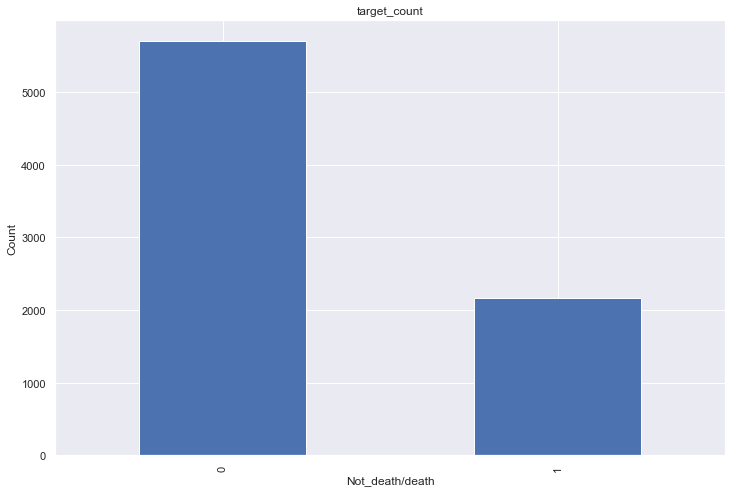

In [93]:
sns.set(rc={'figure.figsize':(12,8)})
equilibre=df['death'].value_counts()
ax=equilibre.plot.bar(title='target_count')
ax.set(xlabel='Not_death/death', ylabel='Count')
print(equilibre)

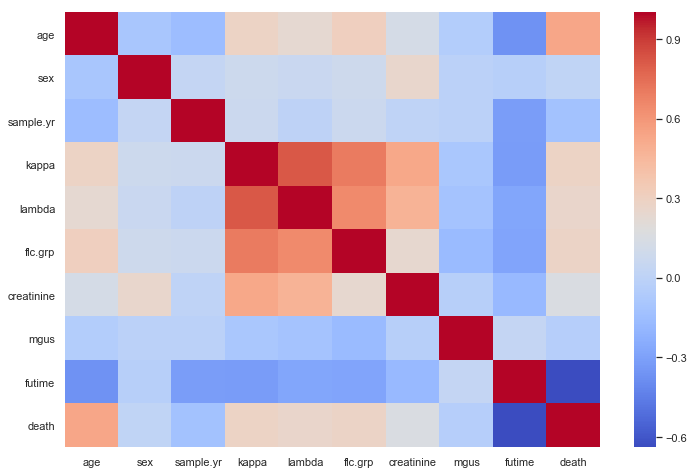

In [94]:
sns.set(rc={'figure.figsize':(12,8)})
corr=df.corr()
ax = sns.heatmap(corr,cmap='coolwarm')

In [95]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

[Text(0, 0.5, 'Probability'), Text(0.5, 0, 'Age')]

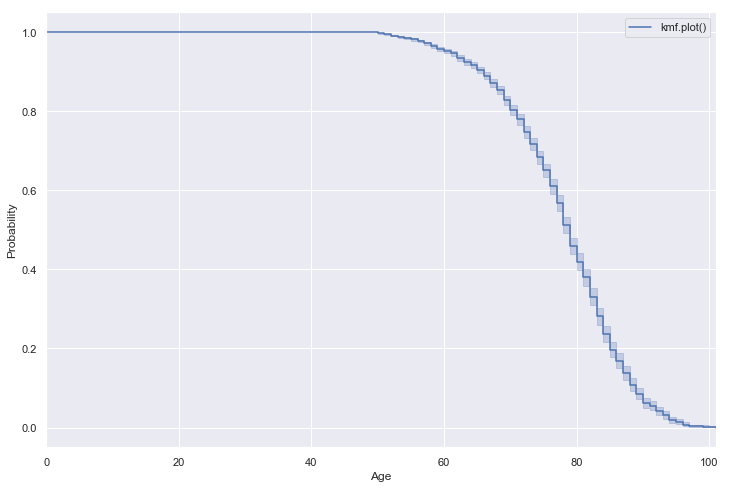

In [96]:
sns.set(rc={'figure.figsize':(12,8)})
kmf = KaplanMeierFitter()
kmf.fit(df['age'], df['death'], label="kmf.plot()")
ax=kmf.plot()
ax.set(xlabel='Age', ylabel='Probability')

In [97]:
cols= ['age', 'sex', 'sample.yr', 'kappa', 'lambda', 'flc.grp', 'creatinine', 'mgus', 'futime', 'death']
df = df[cols]
df.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death
0,97,0,1997,5.70,4.860,10,1.7,0,85,1
1,92,0,2000,0.87,0.683,1,0.9,0,1281,1
2,94,0,1997,4.36,3.850,10,1.4,0,69,1
3,92,0,1996,2.42,2.220,9,1.0,0,115,1
4,93,0,1996,1.32,1.690,6,1.1,0,1039,1


In [98]:
cph = CoxPHFitter()
cph.fit(df, duration_col='age',  event_col='death')

estimation=cph.baseline_survival_
 
hazard=cph.baseline_cumulative_hazard_
print(cph.score_)
print(cph.summary)

0.6697598076249592
                coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
sex         0.584791   1.794616  0.045859        0.494910        0.674673   
sample.yr  -0.052574   0.948784  0.016679       -0.085264       -0.019884   
kappa      -0.102398   0.902670  0.036556       -0.174047       -0.030749   
lambda      0.045062   1.046093  0.029454       -0.012666        0.102790   
flc.grp    -0.047641   0.953476  0.010977       -0.069156       -0.026126   
creatinine -0.082017   0.921256  0.061421       -0.202401        0.038367   
mgus       -0.074836   0.927896  0.254039       -0.572744        0.423071   
futime     -0.000189   0.999811  0.000015       -0.000219       -0.000159   

            exp(coef) lower 95%  exp(coef) upper 95%          z             p  \
sex                    1.640350             1.963390  12.752021  3.037665e-37   
sample.yr              0.918270             0.980313  -3.152099  1.621014e-03   
kappa                  0.840258             

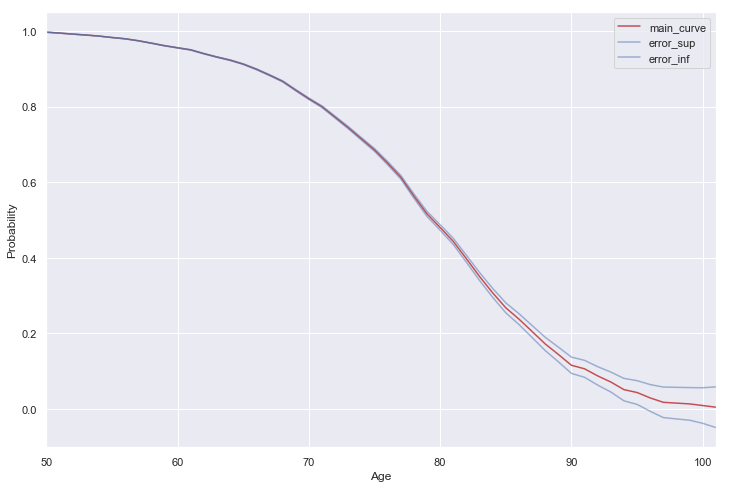

In [99]:
sns.set(rc={'figure.figsize':(12,8)})
hazard['curve']=estimation.values
hazard['curve1']=hazard['curve']+(hazard['baseline cumulative hazard']/100)
hazard['curve2']=hazard['curve']-(hazard['baseline cumulative hazard']/100)

ax=hazard['curve'].plot(color='r',label='main_curve')
hazard['curve1'].plot(color='b',alpha=0.5,ax=ax,label='error_sup')
hazard['curve2'].plot(color='b',alpha=0.5,ax=ax,label='error_inf')
ax.set(xlabel='Age', ylabel='Probability')
ax.legend()

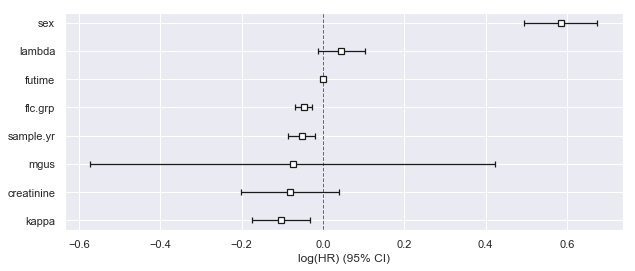

In [113]:
sns.set(rc={'figure.figsize':(10,4)})
cph.plot()

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Mgus')]

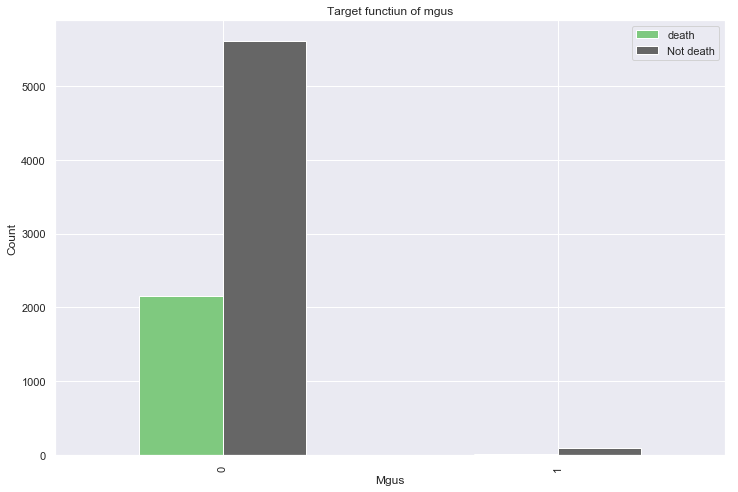

In [101]:
sns.set(rc={'figure.figsize':(12,8)})
total_1=df['mgus'].loc[df['death']==0].value_counts()
total_2=df['mgus'].loc[df['death']==1].value_counts()
data=pd.DataFrame({'death':total_2,'Not death':total_1})
ax=data.plot.bar(title='Target functiun of mgus',colormap='Accent')
ax.set(xlabel='Mgus', ylabel='Count')

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'male/female')]

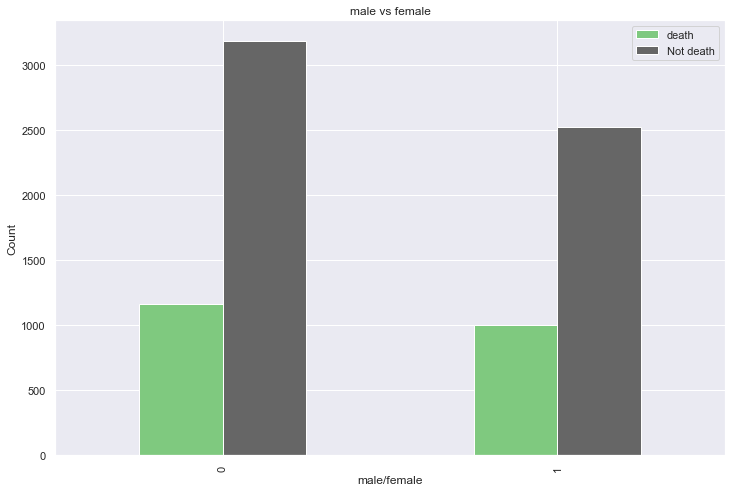

In [102]:
total_1=df['sex'].loc[df['death']==0].value_counts()
total_2=df['sex'].loc[df['death']==1].value_counts()
data=pd.DataFrame({'death':total_2,'Not death':total_1})

ax=data.plot.bar(colormap='Accent',label='',title ='male vs female')
ax.set(xlabel='male/female', ylabel='Count')

[Text(0, 0.5, 'Probability'), Text(0.5, 0, 'age')]

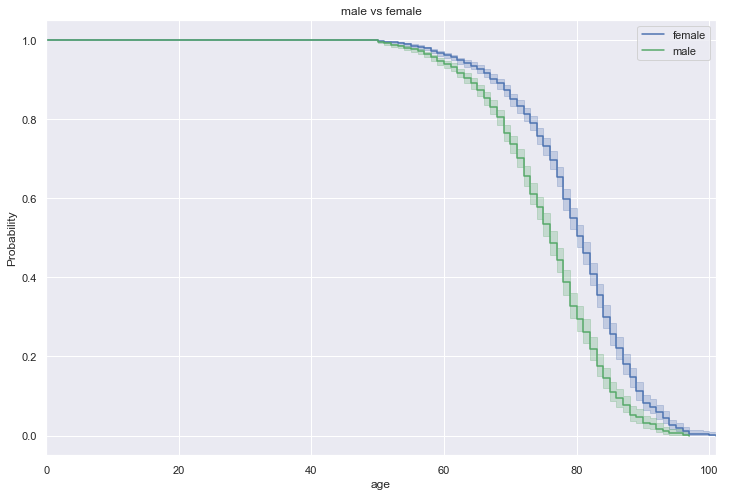

In [105]:
sns.set(rc={'figure.figsize':(12,8)})
total_1=df[['sex','age','death']].loc[df['sex']==0]
total_2=df[['sex','age','death']].loc[df['sex']==1]

kmf = KaplanMeierFitter()
kmf.fit(total_1['age'], total_1['death'], label="kmf.plot()")
ax=kmf.plot(color='b',label='female')

kmf = KaplanMeierFitter()
kmf.fit(total_2['age'], total_2['death'], label="kmf.plot()")
kmf.plot(color='g',title='male vs female',ax=ax,label='male')

ax.set(xlabel='age', ylabel='Probability')

[Text(17.246875000000003, 0.5, 'Count'), Text(0.5, 17.200000000000003, 'age')]

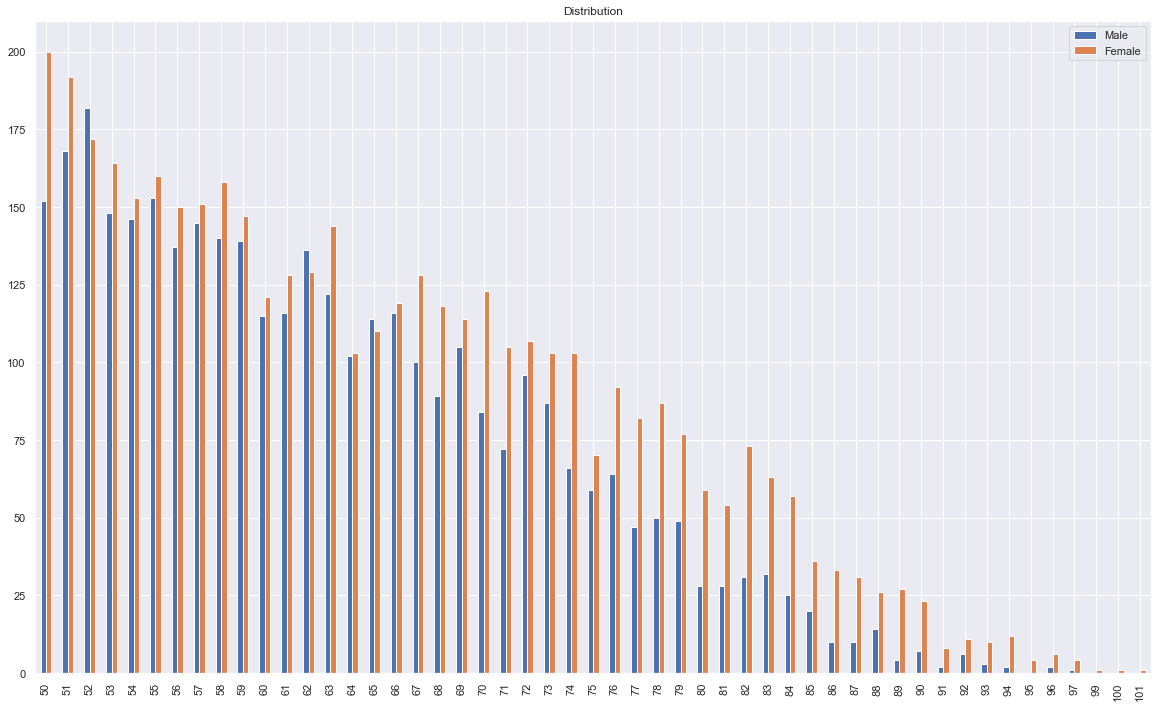

In [104]:
sns.set(rc={'figure.figsize':(12,8)})
total=df[['age','sex']].loc[df['death']==1]
total_1=df['age'].loc[df['sex']==0].value_counts()
total_2=df['age'].loc[df['sex']==1].value_counts()
sns.set(rc={'figure.figsize':(20,12)})


data=pd.DataFrame({'Male':total_2,'Female':total_1})
data.plot.bar(title='Distribution')
#total_2=data[['age','target']].loc[data['sex']==1]
#group1=total_2.groupby('age').size()
#group1.plot.bar(colormap='Accent',label='',title ='male and female by age',ax=ax,color='r',stack=True)
ax.set(xlabel='age', ylabel='Count')